In [ ]:
# ============================================================================
# CONFIGURATION - Modify these variables for different experiments
# ============================================================================

import os

# Data paths
dir_local = '/home/study/IdeaProjects/Graph-Machine-Learning/Temporal_RSR/data'
dir_kaggle = '/kaggle/input/rsr-dataset/Data/'

# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# Dataset parameters
num_companies = 150  # max is 1026
num_days = 1245
num_features = 5
market = "NYSE"  # or "NYSE"

# Temporal parameters
window_size = 20  # Lookback period for temporal models
prediction_horizon = 1  # How many days ahead to predict

# Train/Val/Test split (should sum to 1.0)
train_split = 0.8  # 80% for training
val_split = 0.1    # 10% for validation
test_split = 0.1   # 10% for test

# Graph parameters
K = 5  # Number of graph hops for GNN models
calculate_correlation = False

# ============================================================================
# MODEL CONFIGURATION - Activate/Deactivate features
# ============================================================================

MODEL_CONFIG = {
    # Which model to train
    'use_gvar': False,      # Simple G-VAR baseline
    'use_gcn': False,       # Pure GCN model
    'use_gat': True,        # GAT model (attention-based)
    
    # Graph features
    'use_industry_relations': True,   # Use industry relationship data
    'use_wiki_relations': True,       # Use Wikipedia relationship data
    'use_graph_structure': True,      # If False, uses identity matrix (no graph)
    
    # Model architecture
    'hidden_dim': 15,                 # Hidden layer dimension
    'num_attention_heads': 2,         # For GAT model
    'dropout': 0.5,                   # Dropout rate
    
    # Training parameters
    'learning_rate': 0.001,
    'weight_decay': 0.0,              # L2 regularization
    'batch_training': False,          # If True, use mini-batches (not implemented yet)
    
    # Feature engineering
    'normalize_features': False,      # Normalize input features
    'use_all_features': True,         # Use all 5 stock features
}

# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

train_batch = 1
val_batch = 1
epochs = 20
val_min_num = 10
use_kfold = False
early_stopping_patience = 150  # Stop if no improvement for N epochs

# Environment detection
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle!")
    dir = dir_kaggle
    train_batch = 32
    val_batch = 32
    epochs = 1000
    num_companies = 1026
    calculate_correlation = True
else:
    dir = dir_local
    print("Running locally!")

SAVE_PREPROCESSED_DATA = False  # Set to True to save preprocessed data

# ============================================================================
# PRINT CONFIGURATION SUMMARY
# ============================================================================

print(f"\n{'='*60}")
print(f"EXPERIMENT CONFIGURATION")
print(f"{'='*60}")
print(f"Dataset:")
print(f"  Market: {market}")
print(f"  Companies: {num_companies}")
print(f"  Features: {num_features}")
print(f"  Window size: {window_size}")
print(f"  Prediction horizon: {prediction_horizon}")

print(f"\nData Split:")
print(f"  Train: {train_split*100:.0f}%")
print(f"  Val:   {val_split*100:.0f}%")
print(f"  Test:  {test_split*100:.0f}%")

print(f"\nModel Configuration:")
active_model = [k.replace('use_', '').upper() for k, v in MODEL_CONFIG.items() if k.startswith('use_') and v and k in ['use_gvar', 'use_gcn', 'use_gat']]
print(f"  Active model: {active_model[0] if active_model else 'NONE'}")
print(f"  Graph structure: {'Yes' if MODEL_CONFIG['use_graph_structure'] else 'No (identity)'}")
print(f"  Industry relations: {'Yes' if MODEL_CONFIG['use_industry_relations'] else 'No'}")
print(f"  Wiki relations: {'Yes' if MODEL_CONFIG['use_wiki_relations'] else 'No'}")
print(f"  Hidden dim: {MODEL_CONFIG['hidden_dim']}")
print(f"  Learning rate: {MODEL_CONFIG['learning_rate']}")

print(f"\nTraining:")
print(f"  Epochs: {epochs}")
print(f"  Graph hops (K): {K}")
print(f"  Early stopping patience: {early_stopping_patience}")
print(f"{'='*60}\n")

# Stock Prediction with Graph Neural Networks

## 🎯 Quick Start Guide

### Running Different Experiments

All experiments are controlled from **Cell 1 (Configuration)**. Simply modify the values and restart the kernel:

```python
# Example 1: Test with fewer companies
num_companies = 50
window_size = 20
MODEL_CONFIG['use_gat'] = True

# Example 2: Disable graph structure (baseline)
MODEL_CONFIG['use_graph_structure'] = False

# Example 3: Use only industry relations
MODEL_CONFIG['use_wiki_relations'] = False
MODEL_CONFIG['use_industry_relations'] = True

# Example 4: Try different model
MODEL_CONFIG['use_gat'] = False
MODEL_CONFIG['use_gcn'] = True
```

### Key Configuration Options

**MODEL_CONFIG dictionary:**
- `use_gvar`, `use_gcn`, `use_gat`: Choose which model to train
- `use_graph_structure`: Set to False for baseline (no graph)
- `use_industry_relations`: Include/exclude industry relationship data
- `use_wiki_relations`: Include/exclude Wikipedia relationship data
- `hidden_dim`: Size of hidden layers
- `learning_rate`: Optimizer learning rate
- `dropout`: Regularization parameter

**Data splits:**
- `train_split = 0.8`: 80% of timesteps for training
- `val_split = 0.1`: 10% for validation
- `test_split = 0.1`: 10% for testing
- All splits preserve temporal order (no shuffling!)

---

## 📁 Notebook Structure

### 1. Configuration (Cell 1)
- **Modify this cell** to control all experiments
- `MODEL_CONFIG` dictionary for feature flags
- Train/val/test split ratios
- All hyperparameters in one place

### 2. Dependencies & Setup (Cells 2-3)
- Package installation and imports
- Device detection (CPU/GPU)

### 3. Data Loading Functions (Cells 4-5)
- `load_EOD_data()`: Load stock price data
- `load_relation_data()`: Load company relationship data

### 4. Data Loading (Cells 6-12)
- Load market data (NASDAQ/NYSE)
- Load company relationships (industry, wiki)
- **Subsample to `num_companies`** (Cell 12)

### 5. Utility Functions (Cell 15)
- `build_adjacency_matrix()`: Create normalized adjacency (respects config flags)
- `build_graph_shift_operator()`: Create GCN-style normalization
- `prepare_data()`: Create sliding window datasets
- `temporal_train_val_test_split()`: **Split by time** (80/10/10)
- `calculate_loss()`: Masked loss computation

### 6. Data Preparation (Cells 17-18)
- Convert to PyTorch tensors
- Build graph structures (respects config flags)
- Create training data with sliding windows
- **Split into train/val/test** temporally

### 7. Model Definitions (Cells 19-26)
- **GVarModel** (Cell 20): Vector autoregression baseline
- **GCNModel** (Cell 24): Graph convolutional network
- **GCNGATModel** (Cell 26): Graph attention network

### 8. Training & Evaluation (Cells 27-28)
- **Cell 27**: Full training loop with:
  - Train/validation monitoring
  - Early stopping
  - Test set evaluation
  - Best model selection
- **Cell 28**: Training visualization (loss curves)

---

## ✅ Feature Verification

The notebook **automatically verifies** that all 5 stock features are being used:
- Opens: High, Low, Close, Adj Close, Volume
- Check output in Cell 27 for confirmation

---

## 🧪 Testing Different Configurations

### Example 1: Ablation Study (Graph vs No Graph)

**Step 1:** With graph structure
```python
MODEL_CONFIG['use_graph_structure'] = True
```

**Step 2:** Without graph structure (baseline)
```python
MODEL_CONFIG['use_graph_structure'] = False  # Uses identity matrix
```

Restart kernel and compare test set performance!

### Example 2: Relation Type Comparison

Test which relations help more:
```python
# Only industry
MODEL_CONFIG['use_industry_relations'] = True
MODEL_CONFIG['use_wiki_relations'] = False

# Only wiki
MODEL_CONFIG['use_industry_relations'] = False
MODEL_CONFIG['use_wiki_relations'] = True

# Both (default)
MODEL_CONFIG['use_industry_relations'] = True
MODEL_CONFIG['use_wiki_relations'] = True
```

### Example 3: Model Comparison

```python
# Test GAT
MODEL_CONFIG['use_gat'] = True
MODEL_CONFIG['use_gcn'] = False
MODEL_CONFIG['use_gvar'] = False

# Test GCN (uncomment alternative training cells)
MODEL_CONFIG['use_gat'] = False
MODEL_CONFIG['use_gcn'] = True
```

### Example 4: Hyperparameter Tuning

```python
MODEL_CONFIG['learning_rate'] = 0.0001  # Lower LR
MODEL_CONFIG['hidden_dim'] = 32         # Bigger model
MODEL_CONFIG['dropout'] = 0.3           # Less regularization
epochs = 100                             # More training
```

---

## 📊 Understanding the Output

### Training Progress
```
Epoch [  1/20] | Train Loss: 0.328155 | Val Loss: 0.350221
```
- **Train Loss**: MSE on training data
- **Val Loss**: MSE on validation data (used for early stopping)

### Final Evaluation
```
Final MSE Loss:
  Train: 0.045123
  Val:   0.052341
  Test:  0.048765
```
- **Test Loss**: Performance on unseen future timesteps
- Lower is better!

### RMSE (Root Mean Squared Error)
More interpretable than MSE - in same units as stock prices.

---

## 💡 Tips

1. **Always restart kernel** when changing configuration
2. **Use temporal split** - never shuffle time series data!
3. **Check validation loss** - if much higher than train loss → overfitting
4. **Early stopping** prevents overtraining (patience = 20 epochs)
5. **Test set is sacred** - only look at it for final evaluation!

---

In [2]:
%pip install torch-geometric
%pip install statsmodels


Error processing line 1 of /home/study/anaconda3/envs/Graph-Machine-Learning/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 195, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Error processing line 1 of /home/study/anaconda3/envs/Graph-Machine-Learning/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 195, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to 

In [3]:
# ============================================================================
# IMPORTS
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch_geometric.nn import GATConv
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
"""
COPIED FROM THE PAPER
source code: https://github.com/fulifeng/Temporal_Relational_Stock_Ranking
"""
def load_EOD_data(data_path, market_name, tickers, steps=1):
    eod_data = []
    masks = []
    ground_truth = []
    base_price = []

    # Determine the expected number of rows based on the first ticker's data
    first_ticker_path = os.path.join(data_path, market_name + '_' + tickers[0] + '_1.csv')
    try:
        first_df = pd.read_csv(first_ticker_path, header=None)
        num_days = first_df.shape[0] - (1 if market_name == 'NASDAQ' else 0) # Remove last row for NASDAQ
        num_features = first_df.shape[1] - 1 # Exclude the date column
    except Exception as e:
        print(f"Error reading first ticker file {first_ticker_path}: {e}")
        return None, None, None, None

    eod_data = np.zeros([len(tickers), num_days, num_features], dtype=np.float32)
    masks = np.ones([len(tickers), num_days], dtype=np.float32)
    ground_truth = np.zeros([len(tickers), num_days], dtype=np.float32) # We're not using this one
    base_price = np.zeros([len(tickers), num_days], dtype=np.float32)

    for index, ticker in enumerate(tickers):
        if index % 50 == 0:
          print(f"Processed [{index}/{tickers.shape[0]}] tickers")
        single_EOD_path = os.path.join(data_path, market_name + '_' + ticker + '_1.csv')

        try:
            single_df = pd.read_csv(single_EOD_path, header=None)
            if market_name == 'NASDAQ':
                single_df = single_df[:-1] # remove the last day since lots of missing data

            # Handle missing values (-1234)
            single_EOD = single_df.values
            mask_row_indices, mask_col_indices = np.where(np.abs(single_EOD + 1234) < 1e-8)
            single_EOD[mask_row_indices, mask_col_indices] = 1.1 # Replace missing values

            # Update masks based on missing closing price
            missing_close_indices = np.where(np.abs(single_EOD[:, -1] + 1234) < 1e-8)[0]
            masks[index, missing_close_indices] = 0.0

            eod_data[index, :, :] = single_EOD[:, 1:] # Exclude date column
            base_price[index, :] = single_EOD[:, -1]

        except Exception as e:
            print(f"Error reading ticker file {single_EOD_path}: {e}")
            # Mark all days for this ticker as invalid if file reading fails
            masks[index, :] = 0.0


    print('eod data shape:', eod_data.shape)
    return eod_data, masks, ground_truth, base_price

In [5]:
"""
COPIED FROM THE PAPER
source code: https://github.com/fulifeng/Temporal_Relational_Stock_Ranking
"""
def load_relation_data(relation_file):
    relation_encoding = np.load(relation_file)
    print('relation encoding shape:', relation_encoding.shape)
    rel_shape = [relation_encoding.shape[0], relation_encoding.shape[1]]
    mask_flags = np.equal(np.zeros(rel_shape, dtype=int),
                          np.sum(relation_encoding, axis=2))
    mask = np.where(mask_flags, np.ones(rel_shape) * -1e9, np.zeros(rel_shape))
    return relation_encoding, mask

# Loading data

In [6]:
# market = "NYSE"
market = "NASDAQ"

In [7]:
industry_encodings, industry_mask = load_relation_data(dir+f'/relation/sector_industry/{market}_industry_relation.npy')

relation encoding shape: (1026, 1026, 97)


In [8]:
wiki_encodings, wiki_mask = load_relation_data(dir+f'/relation/wikidata/{market}_wiki_relation.npy')

relation encoding shape: (1026, 1026, 43)


In [9]:
# Load company names
tickers = np.loadtxt(dir+f'/{market}_tickers.csv', dtype=str)
print('tickers shape (# of companies):', tickers.shape)

tickers shape (# of companies): (1026,)


In [10]:
eod_data, eod_masks, eod_ground_truth, eod_base_price = load_EOD_data(dir+"/2013-01-01", market, tickers)

Processed [0/1026] tickers
Processed [50/1026] tickers
Processed [100/1026] tickers
Processed [150/1026] tickers
Processed [200/1026] tickers
Processed [250/1026] tickers
Processed [300/1026] tickers
Processed [350/1026] tickers
Processed [400/1026] tickers
Processed [450/1026] tickers
Processed [500/1026] tickers
Processed [550/1026] tickers
Processed [600/1026] tickers
Processed [650/1026] tickers
Processed [700/1026] tickers
Processed [750/1026] tickers
Processed [800/1026] tickers
Processed [850/1026] tickers
Processed [900/1026] tickers
Processed [950/1026] tickers
Processed [1000/1026] tickers
eod data shape: (1026, 1245, 5)


In [11]:
# ============================================================================
# SUBSAMPLE DATA TO num_companies
# ============================================================================
# This cell ensures all data uses the same subset of companies consistently

print(f"Subsampling to {num_companies} companies...")

# Subsample relation data (company x company matrices)
wiki_encodings = wiki_encodings[:num_companies, :num_companies, :]
wiki_mask = wiki_mask[:num_companies, :num_companies]
industry_encodings = industry_encodings[:num_companies, :num_companies, :]
industry_mask = industry_mask[:num_companies, :num_companies]

# Subsample EOD data (reload with subset of tickers)
eod_data, eod_masks, eod_ground_truth, eod_base_price = load_EOD_data(
    dir + "/2013-01-01", 
    market, 
    tickers[:num_companies]
)

print(f"\nSubsampled data shapes:")
print(f"  EOD data: {eod_data.shape}")
print(f"  Industry encodings: {industry_encodings.shape}")
print(f"  Wiki encodings: {wiki_encodings.shape}")

Subsampling to 150 companies...
Processed [0/150] tickers
Processed [50/150] tickers
Processed [100/150] tickers
eod data shape: (150, 1245, 5)

Subsampled data shapes:
  EOD data: (150, 1245, 5)
  Industry encodings: (150, 150, 97)
  Wiki encodings: (150, 150, 43)


# Graph based Models

In [12]:
# ============================================================================
# UTILITY FUNCTIONS - Graph and Data Preparation
# ============================================================================

def build_adjacency_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device):
    """
    Build normalized adjacency matrix from relation encodings and masks
    
    Args:
        industry_encodings: [num_companies, num_companies, num_relation_types]
        industry_mask: [num_companies, num_companies] (-1e9 for no relation, 0 for valid)
        wiki_encodings: [num_companies, num_companies, num_relation_types]
        wiki_mask: [num_companies, num_companies]
    
    Returns:
        adjacency_matrix: [num_companies, num_companies] - normalized adjacency
    """
    # Combine relation encodings by summing across relation types
    industry_adj = torch.sum(industry_encodings, dim=-1) if MODEL_CONFIG['use_industry_relations'] else 0
    wiki_adj = torch.sum(wiki_encodings, dim=-1) if MODEL_CONFIG['use_wiki_relations'] else 0
    
    # Combine both relation types
    combined_adj = industry_adj + wiki_adj
    
    # Apply masks: where mask is -1e9 (no relation), set adjacency to 0
    combined_mask = industry_mask + wiki_mask
    combined_adj = torch.where(combined_mask < -1e8, torch.zeros_like(combined_adj), combined_adj)
    
    # If not using graph structure, return identity matrix
    if not MODEL_CONFIG['use_graph_structure']:
        return torch.eye(combined_adj.shape[0], device=device)
    
    # Normalize: row-wise normalization (each row sums to 1)
    row_sums = combined_adj.sum(dim=1, keepdim=True)
    adjacency_matrix = combined_adj / (row_sums + 1e-8)
    
    return adjacency_matrix.to(device)


def build_graph_shift_operator(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device):
    """
    Build graph shift operator (symmetric normalized adjacency) for GCN models
    Using D^(-1/2) * A * D^(-1/2) normalization
    
    Returns:
        graph_shift_operator: [num_companies, num_companies]
    """
    # Combine relation encodings
    industry_adj = torch.sum(industry_encodings, dim=-1) if MODEL_CONFIG['use_industry_relations'] else 0
    wiki_adj = torch.sum(wiki_encodings, dim=-1) if MODEL_CONFIG['use_wiki_relations'] else 0
    combined_adj = industry_adj + wiki_adj
    
    # Apply masks
    combined_mask = industry_mask + wiki_mask
    combined_adj = torch.where(combined_mask < -1e8, torch.zeros_like(combined_adj), combined_adj)
    
    # If not using graph structure, return identity matrix
    if not MODEL_CONFIG['use_graph_structure']:
        return torch.eye(combined_adj.shape[0], device=device)
    
    # Symmetric normalization: D^(-1/2) * A * D^(-1/2)
    degree_matrix = torch.diag(torch.pow(torch.sum(combined_adj, dim=1), -0.5))
    graph_shift_operator = degree_matrix @ combined_adj.float() @ degree_matrix
    
    return graph_shift_operator.to(device)


def prepare_data(eod_data, masks, base_price, device, window_size=20, prediction_horizon=1):
    """
    Create sliding windows for time series prediction with mask handling
    
    Args:
        eod_data: [num_companies, num_days, num_features]
        masks: [num_companies, num_days] - 1.0 for valid, 0.0 for missing
        base_price: [num_companies, num_days] - closing price of stock
        window_size: Number of historical days to use as input
        prediction_horizon: Number of days ahead to predict (usually 1)
    
    Returns:
        X: Input windows [num_samples, num_companies, window_size, num_features]
        y: Target prices [num_samples, num_companies, prediction_horizon]
        sample_masks: Valid sample indicators [num_samples, num_companies]
    """
    num_companies, num_days, num_features = eod_data.shape
    num_samples = num_days - window_size - prediction_horizon + 1
    
    X = torch.zeros(num_samples, num_companies, window_size, num_features, device=device)
    y = torch.zeros(num_samples, num_companies, prediction_horizon, device=device)
    sample_masks = torch.zeros(num_samples, num_companies, device=device)
    
    for i in range(num_samples):
        X[i] = eod_data[:, i:i+window_size, :]
        y[i, :, :] = base_price[:, i+window_size:i+window_size+prediction_horizon]
        
        # A sample is valid if all days in the window AND the target day are valid
        window_valid = masks[:, i:i+window_size].min(dim=1)[0]  # [num_companies]
        target_valid = masks[:, i+window_size:i+window_size+prediction_horizon].min(dim=1)[0]
        sample_masks[i] = window_valid * target_valid
    
    return X, y, sample_masks


def temporal_train_val_test_split(X, y, masks, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Split data temporally into train/validation/test sets
    IMPORTANT: Splits based on TIME, not randomly (preserves temporal order)
    
    Args:
        X: [num_samples, num_companies, window_size, num_features]
        y: [num_samples, num_companies, prediction_horizon]
        masks: [num_samples, num_companies]
        train_ratio: Proportion for training (e.g., 0.8 = 80%)
        val_ratio: Proportion for validation (e.g., 0.1 = 10%)
        test_ratio: Proportion for test (e.g., 0.1 = 10%)
    
    Returns:
        Dictionary with train/val/test splits for X, y, and masks
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    num_samples = X.shape[0]
    
    # Calculate split indices based on time
    train_end = int(num_samples * train_ratio)
    val_end = int(num_samples * (train_ratio + val_ratio))
    
    # Split data temporally
    splits = {
        'X_train': X[:train_end],
        'y_train': y[:train_end],
        'masks_train': masks[:train_end],
        
        'X_val': X[train_end:val_end],
        'y_val': y[train_end:val_end],
        'masks_val': masks[train_end:val_end],
        
        'X_test': X[val_end:],
        'y_test': y[val_end:],
        'masks_test': masks[val_end:],
    }
    
    # Print split information
    print(f"\nTemporal Data Split:")
    print(f"  Train: samples [0:{train_end}] = {splits['X_train'].shape[0]} timesteps")
    print(f"  Val:   samples [{train_end}:{val_end}] = {splits['X_val'].shape[0]} timesteps")
    print(f"  Test:  samples [{val_end}:{num_samples}] = {splits['X_test'].shape[0]} timesteps")
    
    print(f"\n  Valid train samples: {splits['masks_train'].sum().item():.0f} / {splits['masks_train'].numel()}")
    print(f"  Valid val samples:   {splits['masks_val'].sum().item():.0f} / {splits['masks_val'].numel()}")
    print(f"  Valid test samples:  {splits['masks_test'].sum().item():.0f} / {splits['masks_test'].numel()}")
    
    return splits


def adjacency_to_edges(adjacency_matrix):
    """
    Convert adjacency matrix to edge_index and edge_weight for PyTorch Geometric
    
    Args:
        adjacency_matrix: [num_companies, num_companies] tensor
        
    Returns:
        edge_index: [2, num_edges] - edge connectivity
        edge_weight: [num_edges, 1] - edge weights
    """
    adj_np = adjacency_matrix.cpu().numpy()
    rows, cols = np.where(adj_np > 0)
    edge_weights = adj_np[rows, cols]
    edge_index = torch.tensor(np.stack([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(edge_weights, dtype=torch.float32).view(-1, 1)
    return edge_index, edge_weight


def calculate_loss(predictions, targets, masks, criterion):
    """
    Calculate masked loss (only compute loss on valid samples)
    
    Args:
        predictions: Model predictions [batch, companies, output_dim]
        targets: Ground truth [batch, companies, output_dim]
        masks: Valid sample mask [batch, companies]
        criterion: Loss function (should have reduction='none')
    
    Returns:
        loss: Scalar loss value
    """
    loss_per_sample = criterion(predictions, targets)
    masked_loss = loss_per_sample * masks.unsqueeze(-1)
    num_valid = masks.sum() + 1e-8
    loss = masked_loss.sum() / num_valid
    return loss


print("Utility functions loaded successfully!")

Utility functions loaded successfully!


In [13]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [14]:
# ============================================================================
# CONVERT DATA TO TENSORS
# ============================================================================

print(f"Converting data to tensors for {num_companies} companies...")

# Convert to tensors - use the already subsampled data
eod_data_tensor = torch.tensor(eod_data, dtype=torch.float32)
masks_tensor = torch.tensor(eod_masks, dtype=torch.float32)
price_prediction = torch.tensor(eod_base_price, dtype=torch.float32)

# Relation data tensors
industry_encodings_tensor = torch.tensor(industry_encodings, dtype=torch.float32)
industry_mask_tensor = torch.tensor(industry_mask, dtype=torch.float32)
wiki_encodings_tensor = torch.tensor(wiki_encodings, dtype=torch.float32)
wiki_mask_tensor = torch.tensor(wiki_mask, dtype=torch.float32)

print(f"\nTensor shapes:")
print(f"  EOD data: {eod_data_tensor.shape}")
print(f"  Masks: {masks_tensor.shape}")
print(f"  Price prediction: {price_prediction.shape}")
print(f"  Industry encodings: {industry_encodings_tensor.shape}")
print(f"  Wiki encodings: {wiki_encodings_tensor.shape}")

Converting data to tensors for 150 companies...

Tensor shapes:
  EOD data: torch.Size([150, 1245, 5])
  Masks: torch.Size([150, 1245])
  Price prediction: torch.Size([150, 1245])
  Industry encodings: torch.Size([150, 150, 97])
  Wiki encodings: torch.Size([150, 150, 43])


In [15]:
# ============================================================================
# PREPARE TRAINING DATA WITH TRAIN/VAL/TEST SPLIT
# ============================================================================

print(f"Preparing training data with window_size={window_size}, prediction_horizon={prediction_horizon}...")

# Build graph structures
adjacency_matrix = build_adjacency_matrix(
    industry_encodings_tensor, industry_mask_tensor,
    wiki_encodings_tensor, wiki_mask_tensor,
    device=device
)

graph_shift_operator = build_graph_shift_operator(
    industry_encodings_tensor, industry_mask_tensor,
    wiki_encodings_tensor, wiki_mask_tensor,
    device=device
)

# Prepare temporal data with sliding windows
X_all, y_all, masks_all = prepare_data(
    eod_data_tensor, masks_tensor, price_prediction,
    window_size=window_size,
    prediction_horizon=prediction_horizon,
    device=device
)

print(f"\nFull dataset prepared:")
print(f"  X_all: {X_all.shape}")
print(f"  y_all: {y_all.shape}")
print(f"  masks_all: {masks_all.shape}")

# Split data temporally into train/val/test
data_splits = temporal_train_val_test_split(
    X_all, y_all, masks_all,
    train_ratio=train_split,
    val_ratio=val_split,
    test_ratio=test_split
)

# Extract splits for easier access
X_train = data_splits['X_train']
y_train = data_splits['y_train']
masks_train = data_splits['masks_train']

X_val = data_splits['X_val']
y_val = data_splits['y_val']
masks_val = data_splits['masks_val']

X_test = data_splits['X_test']
y_test = data_splits['y_test']
masks_test = data_splits['masks_test']

# Convert adjacency to edge format for GAT models
edge_index, edge_weight = adjacency_to_edges(adjacency_matrix)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)

print(f"\n{'='*60}")
print(f"Graph structure:")
print(f"  Adjacency matrix: {adjacency_matrix.shape}")
print(f"  Edge index: {edge_index.shape}")
print(f"  Edge weight: {edge_weight.shape}")
print(f"  Total edges: {edge_index.shape[1]}")
print(f"{'='*60}")

Preparing training data with window_size=20, prediction_horizon=1...

Full dataset prepared:
  X_all: torch.Size([1225, 150, 20, 5])
  y_all: torch.Size([1225, 150, 1])
  masks_all: torch.Size([1225, 150])

Temporal Data Split:
  Train: samples [0:980] = 980 timesteps
  Val:   samples [980:1102] = 122 timesteps
  Test:  samples [1102:1225] = 123 timesteps

  Valid train samples: 147000 / 147000
  Valid val samples:   18300 / 18300
  Valid test samples:  18450 / 18450

Graph structure:
  Adjacency matrix: torch.Size([150, 150])
  Edge index: torch.Size([2, 176])
  Edge weight: torch.Size([176, 1])
  Total edges: 176


In [16]:
"""
Simple G-VAR (Graph Vector AutoRegression) for Stock Price Prediction
Combines temporal dependencies (VAR) with graph structure (GNN)
Updated to match the paper's data format
"""

# ============================================================================
# Simple G-Var
# ============================================================================

class GVarModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_companies, device, K=2):
        """
        Args:
            input_dim: Number of features * window_size per company
            output_dim: Prediction dimension (1 for return prediction)
            num_companies: Number of stocks (e.g., 150)
            K: Number of graph hops
        """
        super(GVarModel, self).__init__()
        self.device = device
        self.K = K
        self.num_companies = num_companies
        self.output_dim = output_dim

        self.graph_layers = nn.ModuleList([
            nn.Linear(input_dim, 1) for _ in range(K + 1)
        ])

    def forward(self, x, adjacency_matrix):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
            adjacency_matrix: Graph structure [num_companies, num_companies]
        Returns:
            predictions: [batch, num_companies, output_dim]
        """
        batch_size = x.shape[0]

        # Step 1: Extract temporal features for each stock independently
        # Reshape to process all companies' time series
        x_reshaped = x.view(x.shape[0], x.shape[1], -1)  # [batch, companies, time_steps * features]

        # Compute powers of adjacency matrix: A^0 (self), A^1 (neighbors), A^2 (2-hop), ...
        S_powers = [torch.eye(self.num_companies, device=adjacency_matrix.device)]
        for k in range(self.K):
            S_powers.append(torch.matmul(S_powers[-1], adjacency_matrix))

        # Step 2: Aggregate information from k-hop neighbors
        output = torch.zeros(x.shape[0], x.shape[1], self.output_dim, device=self.device)
        for k in range(self.K + 1):
            # Transform features at each hop level
            transformed = self.graph_layers[k](x_reshaped)  # [batch, companies, hidden_dim]

            # Aggregate from k-hop neighbors: S^k @ transformed
            aggregated = torch.matmul(S_powers[k], transformed)  # [batch, companies, hidden_dim]
            output += aggregated

        return output

In [17]:
torch.cuda.empty_cache()

torch.cuda.memory_allocated()

#import gc
#gc.collect()

75154944

In [18]:
# ============================================================================
# ALTERNATIVE TRAINING: G-VAR Model (Commented out - uncomment to use)
# ============================================================================
# Simpler baseline model without graph structure
#
# model = GVarModel(
#     input_dim=num_features * window_size,
#     output_dim=prediction_horizon,
#     num_companies=num_companies,
#     device=device,
#     K=1
# ).to(device)
#
# criterion = nn.MSELoss(reduction='none')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     
#     # Use identity matrix instead of adjacency (no graph structure)
#     predictions = model(X_train, torch.eye(num_companies, device=device))
#     
#     loss_per_sample = criterion(predictions, y_train)
#     masked_loss = loss_per_sample * train_masks.unsqueeze(-1)
#     num_valid = train_masks.sum() + 1e-8
#     loss = masked_loss.sum() / num_valid
#     
#     loss.backward()
#     optimizer.step()
#     
#     if (epoch + 1) % 50 == 0:
#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

pass  # Placeholder to keep cell executable

# GNN

In [19]:
# ============================================================================
# MODEL DEFINITION: GCN (Graph Convolutional Network)
# ============================================================================

class GCNModel(nn.Module):
    """
    Graph Convolutional Network for stock prediction
    Uses graph shift operator for spatial aggregation
    """
    def __init__(self, layers_dim, num_companies, S, device, K=1, L=1):
        """
        Args:
            layers_dim: List of (input_dim, output_dim) tuples for each layer
            num_companies: Number of stocks
            S: Graph shift operator (normalized adjacency)
            device: torch device
            K: Number of graph hops
            L: Number of GCN layers
        """
        super(GCNModel, self).__init__()
        self.device = device
        self.K = K
        self.L = L
        self.num_companies = num_companies
        self.layers_dim = layers_dim
        
        # Compute powers of graph shift operator: S^0, S^1, S^2, ...
        self.S_powers = [S]
        for k in range(self.K):
            self.S_powers.append(self.S_powers[-1] @ S)
        
        # GCN layers
        self.gcn_layer1 = nn.ModuleList([
            nn.Linear(layers_dim[0][0], layers_dim[0][1]) for _ in range(K)
        ])
        self.activation1 = nn.ReLU()
        
        self.gcn_layer2 = nn.ModuleList([
            nn.Linear(layers_dim[1][0], layers_dim[1][1]) for _ in range(K)
        ])
        self.activation2 = nn.ReLU()
    
    def forward(self, x):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
        Returns:
            predictions: [batch, num_companies, output_dim]
        """
        batch_size = x.shape[0]
        x_reshaped = x.view(batch_size, self.num_companies, -1)  # Flatten temporal dimension
        
        # First GCN layer with K-hop aggregation
        x_i = x_reshaped
        output = torch.zeros(batch_size, self.num_companies, self.layers_dim[0][1], device=self.device)
        for k in range(self.K):
            transformed = self.gcn_layer1[k](self.S_powers[k] @ x_i)
            output += transformed
        x_i = self.activation1(output)
        
        # Second GCN layer with K-hop aggregation
        output = torch.zeros(batch_size, self.num_companies, self.layers_dim[1][1], device=self.device)
        for k in range(self.K):
            transformed = self.gcn_layer2[k](self.S_powers[k] @ x_i)
            output += transformed
        x_i = self.activation2(output)
        
        return x_i


print("GCNModel defined successfully!")

GCNModel defined successfully!


In [20]:
# ============================================================================
# MODEL DEFINITION: GCN-GAT (Hybrid using Graph Attention)
# ============================================================================

class GCNGATModel(nn.Module):
    """
    Hybrid model using Graph Attention Networks (GAT) for stock prediction
    Uses attention mechanism to weight neighbor importance
    """
    def __init__(self, layers_dim, num_companies, adjacency_matrix, S, device, edge_index, edge_weight, K=1, L=1):
        """
        Args:
            layers_dim: List of (input_dim, output_dim) tuples for each layer
            num_companies: Number of stocks
            adjacency_matrix: Adjacency matrix for masking
            S: Graph shift operator
            device: torch device
            edge_index: Edge connectivity [2, num_edges]
            edge_weight: Edge weights [num_edges, 1]
            K: Number of graph hops
            L: Number of layers
        """
        super(GCNGATModel, self).__init__()
        self.device = device
        self.K = K
        self.L = L
        self.num_companies = num_companies
        self.layers_dim = layers_dim
        
        # Graph structure
        self.S = S
        self.adjacency_matrix = adjacency_matrix
        self.mask = (self.adjacency_matrix == 0)
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        
        # GAT layer: attention-based aggregation
        # Input: num_features * window_size, Output: prediction_horizon
        self.conv_0 = GATConv(
            in_channels=layers_dim[0][0], 
            out_channels=layers_dim[0][1], 
            heads=MODEL_CONFIG['num_attention_heads'],  # Multi-head attention
            concat=False,  # Average the heads
            dropout=MODEL_CONFIG['dropout'], 
            add_self_loops=True, 
            edge_dim=1,  # Use edge weights
            fill_value=0, 
            bias=True
        )
    
    def forward(self, x):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
        Returns:
            predictions: [batch, num_companies, output_dim]
        """
        batch_size = x.shape[0]
        x_reshaped = x.view(batch_size, self.num_companies, -1)  # Flatten temporal dimension
        
        # Process each batch separately (GAT requires this)
        outputs = []
        for b in range(batch_size):
            out = self.conv_0(x_reshaped[b], self.edge_index, self.edge_weight)
            out = F.relu(out)
            outputs.append(out)
        
        return torch.stack(outputs)


print("GCNGATModel defined successfully!")

GCNGATModel defined successfully!


In [21]:
# ============================================================================
# TRAINING: GCN-GAT Model with Validation and Testing
# ============================================================================

# Only run if GAT model is selected
if not MODEL_CONFIG['use_gat']:
    print("GAT model not selected in configuration. Skipping...")
else:
    # Clear GPU memory
    torch.cuda.empty_cache()
    
    print(f"{'='*60}")
    print(f"TRAINING GCN-GAT MODEL")
    print(f"{'='*60}")
    
    # Verify all 5 features are being used
    print(f"\nFeature verification:")
    print(f"  Input shape: {X_train.shape}")
    print(f"  Features per timestep: {X_train.shape[3]} (should be {num_features})")
    print(f"  Total input dimension: window_size({window_size}) × features({num_features}) = {window_size * num_features}")
    assert X_train.shape[3] == num_features, f"Expected {num_features} features but got {X_train.shape[3]}"
    print(f"  ✓ All {num_features} features are being used!")
    
    # Initialize model
    print(f"\nInitializing GCN-GAT model...")
    model = GCNGATModel(
        layers_dim=[(num_features * window_size, prediction_horizon)],
        num_companies=num_companies,
        adjacency_matrix=adjacency_matrix,
        S=graph_shift_operator,
        device=device,
        edge_index=edge_index,
        edge_weight=edge_weight,
        K=1,
        L=1
    ).to(device)
    
    # Training configuration
    criterion = nn.MSELoss(reduction='none')  # Masked loss
    optimizer = optim.Adam(
        model.parameters(), 
        lr=MODEL_CONFIG['learning_rate'],
        weight_decay=MODEL_CONFIG['weight_decay']
    )
    
    print(f"\nModel configuration:")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Learning rate: {MODEL_CONFIG['learning_rate']}")
    print(f"  Weight decay: {MODEL_CONFIG['weight_decay']}")
    print(f"  Dropout: {MODEL_CONFIG['dropout']}")
    print(f"  Attention heads: {MODEL_CONFIG['num_attention_heads']}")
    
    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    print(f"\n{'='*60}")
    print(f"Starting training for {epochs} epochs...")
    print(f"{'='*60}\n")
    
    # Training loop
    for epoch in range(epochs):
        # ===== TRAINING =====
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_train)  # [batch, companies, prediction_horizon]
        
        # Calculate masked loss
        train_loss = calculate_loss(predictions, y_train, masks_train, criterion)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        # ===== VALIDATION =====
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val)
            val_loss = calculate_loss(val_predictions, y_val, masks_val, criterion)
            val_losses.append(val_loss.item())
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1:3d}/{epochs}] | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement for {early_stopping_patience} epochs)")
            break
    
    # Load best model for final evaluation
    model.load_state_dict(best_model_state)
    
    # ===== FINAL EVALUATION =====
    print(f"\n{'='*60}")
    print(f"FINAL EVALUATION (Best Model)")
    print(f"{'='*60}")
    
    model.eval()
    with torch.no_grad():
        # Train set
        train_predictions = model(X_train)
        final_train_loss = calculate_loss(train_predictions, y_train, masks_train, criterion)
        
        # Validation set
        val_predictions = model(X_val)
        final_val_loss = calculate_loss(val_predictions, y_val, masks_val, criterion)
        
        # Test set
        test_predictions = model(X_test)
        final_test_loss = calculate_loss(test_predictions, y_test, masks_test, criterion)
    
    print(f"\nFinal MSE Loss:")
    print(f"  Train: {final_train_loss.item():.6f}")
    print(f"  Val:   {final_val_loss.item():.6f}")
    print(f"  Test:  {final_test_loss.item():.6f}")
    
    # Calculate RMSE for interpretability
    print(f"\nFinal RMSE:")
    print(f"  Train: {torch.sqrt(final_train_loss).item():.6f}")
    print(f"  Val:   {torch.sqrt(final_val_loss).item():.6f}")
    print(f"  Test:  {torch.sqrt(final_test_loss).item():.6f}")
    
    print(f"\n{'='*60}")
    print(f"Training completed!")
    print(f"{'='*60}")

TRAINING GCN-GAT MODEL

Feature verification:
  Input shape: torch.Size([980, 150, 20, 5])
  Features per timestep: 5 (should be 5)
  Total input dimension: window_size(20) × features(5) = 100
  ✓ All 5 features are being used!

Initializing GCN-GAT model...

Model configuration:
  Total parameters: 209
  Learning rate: 0.001
  Weight decay: 0.0
  Dropout: 0.5
  Attention heads: 2

Starting training for 20 epochs...

Epoch [  1/20] | Train Loss: 1.236391 | Val Loss: 0.387964
Epoch [ 10/20] | Train Loss: 0.373407 | Val Loss: 0.004018
Epoch [ 20/20] | Train Loss: 0.205355 | Val Loss: 0.209496

FINAL EVALUATION (Best Model)

Final MSE Loss:
  Train: 0.158426
  Val:   0.209496
  Test:  0.231408

Final RMSE:
  Train: 0.398028
  Val:   0.457708
  Test:  0.481049

Training completed!


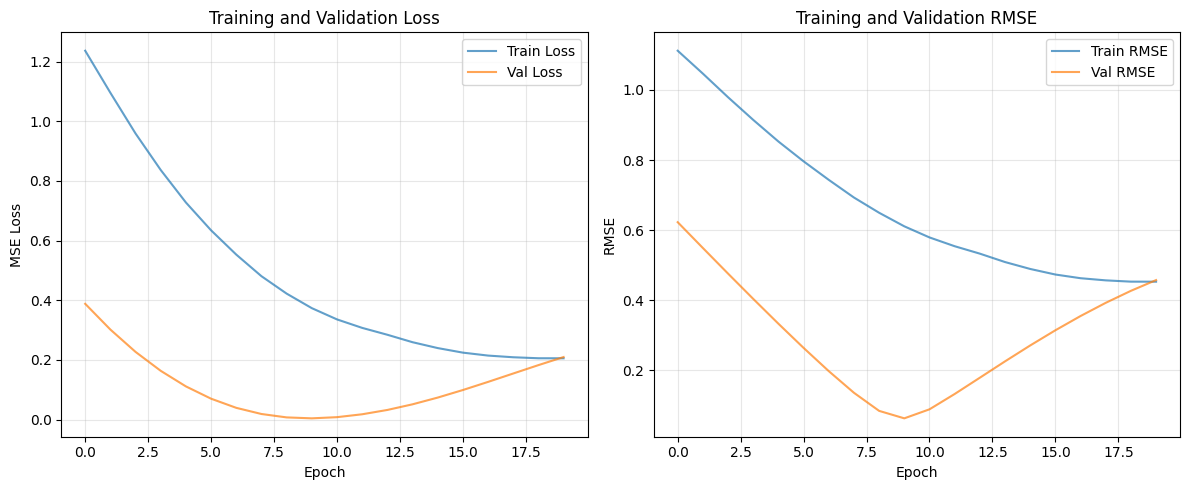


Training statistics:
  Best epoch: 10
  Best val loss: 0.004018
  Final train loss: 0.205355
  Final val loss: 0.209496


In [22]:
# ============================================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================================

if MODEL_CONFIG['use_gat'] and 'train_losses' in locals():
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.7)
    plt.plot(val_losses, label='Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot RMSE (more interpretable)
    plt.subplot(1, 2, 2)
    plt.plot([torch.sqrt(torch.tensor(l)).item() for l in train_losses], label='Train RMSE', alpha=0.7)
    plt.plot([torch.sqrt(torch.tensor(l)).item() for l in val_losses], label='Val RMSE', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining statistics:")
    print(f"  Best epoch: {val_losses.index(min(val_losses)) + 1}")
    print(f"  Best val loss: {min(val_losses):.6f}")
    print(f"  Final train loss: {train_losses[-1]:.6f}")
    print(f"  Final val loss: {val_losses[-1]:.6f}")